<a href="https://colab.research.google.com/github/umberH/2023_datathon_uni_sydney/blob/main/forest_firekaggle_data_import.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Install Prereq libraries

Install the Prerequisites required for this execution. These pre=requisites involve



*   Kaggle
*   List item



In [1]:
! pip install -q kaggle

## Imports

In [2]:
from google.colab import files

import numpy as np
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# matplotlibinline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import itertools
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import sklearn.tree as tree
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [3]:
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"umbreenh","key":"c3171f8b9703289df4fbdc561d14cf08"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
dataset_name = "elikplim/forest-fires-data-set"

!kaggle datasets download -d $dataset_name


ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
myrios/cost-of-living-index-by-country-by-number-2024           Cost of Living Index by Country                      3KB  2024-07-19 06:25:42           3905         57  1.0              
muhammadroshaanriaz/cancer-dataset-risk-of-developing-or-dying  Cancer Dataset (Risk of Developing or Dying)        867B  2024-07-26 20:30:18           1082         21  1.0              
muhammadehsan000/2024-electric-car-data-washington-state        Electric Vehicle Data (1997 - 2024)                  6MB  2024-08-04 10:33:24           1369         36  1.0              
muhammadehsan000/olympic-historical-dataset-1896-2020           O

In [5]:
print(dataset_name.split("/")[1])

forest-fires-data-set


In [6]:
# !mkdir $dataset_name
!unzip {dataset_name.split("/")[1]+".zip"} -d {dataset_name.split("/")[1]}

Archive:  forest-fires-data-set.zip
  inflating: forest-fires-data-set/forestfires.csv  


In [7]:
dataset_df = pd.read_csv("/content/forest-fires-data-set/forestfires.csv")

The target variable is the area burned in forest fires (in hectares), in northeastern Portugal, which is particularly affected by forest fires. A paper by Paulo Cortez and An´ıbal Morais describing and tackling the problem is here: https://core.ac.uk/download/pdf/55609027.pdf (P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, Guimarães, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9).

Documentation also available at UCI: https://archive.ics.uci.edu/ml/datasets/forest+fires. Some notes from the paper:

Some of the features are related to fuel codes: FFMC refers to
moisture content surface litter and influences ignition and fire spread (ranges from 18.7 to 96.20). DMC (1.1 to 291.3) and DC (7.9 to 860.6) are the moisture content of shallow and deep organic layers. ISI (0.0 to 56.10) is a score that correlates with fire velocity spread. RH is relative humidity in percentage (15.0 to 100). Temperature is in Celsius (2.2 to 33.30), wind speed is in km/h (0.40 to 9.40), and rain is in mm/m2 (0.0 to 6.4).

Data were collected from January 2000 to December 2003.

The values denote instant records, as given by station sensors when

the forest fire in question was detected (except for the rain variable, which denotes the accumulated precipitation within the previous 30 minutes).

They find that spatial coordinates (X, Y) and time features are not as important.

Best RMSE: 63.7, Best MAD: 12.7. These are the metrics I'll be using to evaluate ML models.

An area of zero actually means an area less than  
100
m
2
  was burned (note, a hectare is  
10
4
m
2
 ).

Of the weather conditions, the outside temperature is

the most important feature, followed by the accumulated precipitation.

The spatial location of the fires is described with a
9
×
9
 grid corresponding to the (X,Y) coordinates.

In [8]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [9]:
display(dataset_df.dtypes)

,0
X,int64
Y,int64
month,object
day,object
FFMC,float64
DMC,float64
DC,float64
ISI,float64
temp,float64
RH,int64


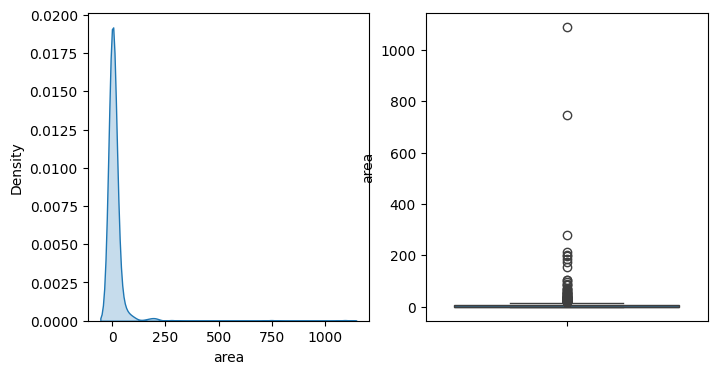

In [10]:
fig, ax =plt.subplots(1,2,figsize=(8,4))
sns.kdeplot(dataset_df['area'],fill=True,ax=ax[0])
sns.boxplot(dataset_df['area'],ax=ax[1])
fig.show()

Skewness: 12.846933533934868
Skewness after log transform: 1.2178376559535011


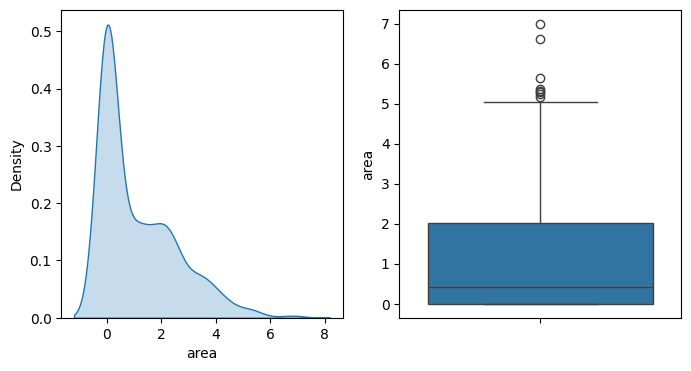

In [11]:
fig, ax =plt.subplots(1,2,figsize=(8,4))
sns.kdeplot(np.log(1+dataset_df['area']),fill=True,ax=ax[0])
sns.boxplot(np.log(1+dataset_df['area']),ax=ax[1])
fig.show()
area_log = np.log(1 + dataset_df['area'])
print('Skewness:',dataset_df['area'].skew())
print('Skewness after log transform:',area_log.skew())

In [12]:
dataset_df.sort_values(['area'], ascending=[False]).head(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
236,2,2,sep,sat,92.5,121.1,674.4,8.6,18.2,46,1.8,0.0,200.94
235,8,6,aug,sun,91.4,142.4,601.4,10.6,19.6,41,5.8,0.0,196.48
420,8,8,aug,wed,91.7,191.4,635.9,7.8,26.2,36,4.5,0.0,185.76
377,2,2,aug,sat,93.7,231.1,715.1,8.4,21.9,42,2.2,0.0,174.63
234,4,5,sep,sat,92.5,121.1,674.4,8.6,17.7,25,3.1,0.0,154.88
233,9,4,sep,tue,84.4,73.4,671.9,3.2,24.3,36,3.1,0.0,105.66


In [13]:
dataset_df[dataset_df['area'] == 0.]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,2,4,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.0
508,1,2,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.0
511,8,6,aug,sun,81.6,56.7,665.6,1.9,27.8,35,2.7,0.0,0.0
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.0


In [14]:
dataset_df[dataset_df['area'] == 0.].describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.0
mean,4.518219,4.226721,90.219028,106.679757,522.878138,8.851822,18.427935,44.894737,3.913360,0.013765,0.0
std,2.230305,1.289898,6.965969,66.300811,264.637833,4.974102,5.344018,17.581779,1.681857,0.100268,0.0
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,4.200000,15.000000,0.900000,0.000000,0.0
25%,3.000000,4.000000,90.200000,51.300000,360.100000,6.300000,15.200000,32.000000,2.700000,0.000000,0.0
50%,4.000000,4.000000,91.600000,103.200000,661.300000,8.400000,18.600000,42.000000,3.600000,0.000000,0.0
75%,6.000000,5.000000,92.600000,142.400000,706.500000,10.600000,21.600000,54.000000,5.150000,0.000000,0.0
max,9.000000,9.000000,96.200000,290.000000,855.300000,56.100000,32.400000,100.000000,8.500000,1.000000,0.0


In [15]:
dataset_df[dataset_df['area'] != 0.].describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,4.807407,4.366667,91.034074,114.707778,570.867037,9.177037,19.311111,43.733333,4.112963,0.028889,24.600185
std,2.383326,1.170740,3.709020,61.786520,229.981242,4.147350,6.179444,15.080059,1.884573,0.398392,86.501635
min,1.000000,2.000000,63.500000,3.200000,15.300000,0.800000,2.200000,15.000000,0.400000,0.000000,0.090000
25%,3.000000,4.000000,90.325000,82.900000,486.500000,6.800000,16.125000,33.000000,2.700000,0.000000,2.140000
50%,5.000000,4.000000,91.700000,111.700000,665.600000,8.400000,20.100000,41.000000,4.000000,0.000000,6.370000
75%,7.000000,5.000000,92.975000,141.300000,721.325000,11.375000,23.400000,53.000000,4.900000,0.000000,15.422500
max,9.000000,9.000000,96.200000,291.300000,860.600000,22.700000,33.300000,96.000000,9.400000,6.400000,1090.840000


## Features


In [16]:
dfa = dataset_df.drop(columns='area')
cat_columns = dfa.select_dtypes(include='object').columns.tolist()
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()
print('Categorical features:',cat_columns)
print('Numerical features:',num_columns)

Categorical features: ['month', 'day']
Numerical features: ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']


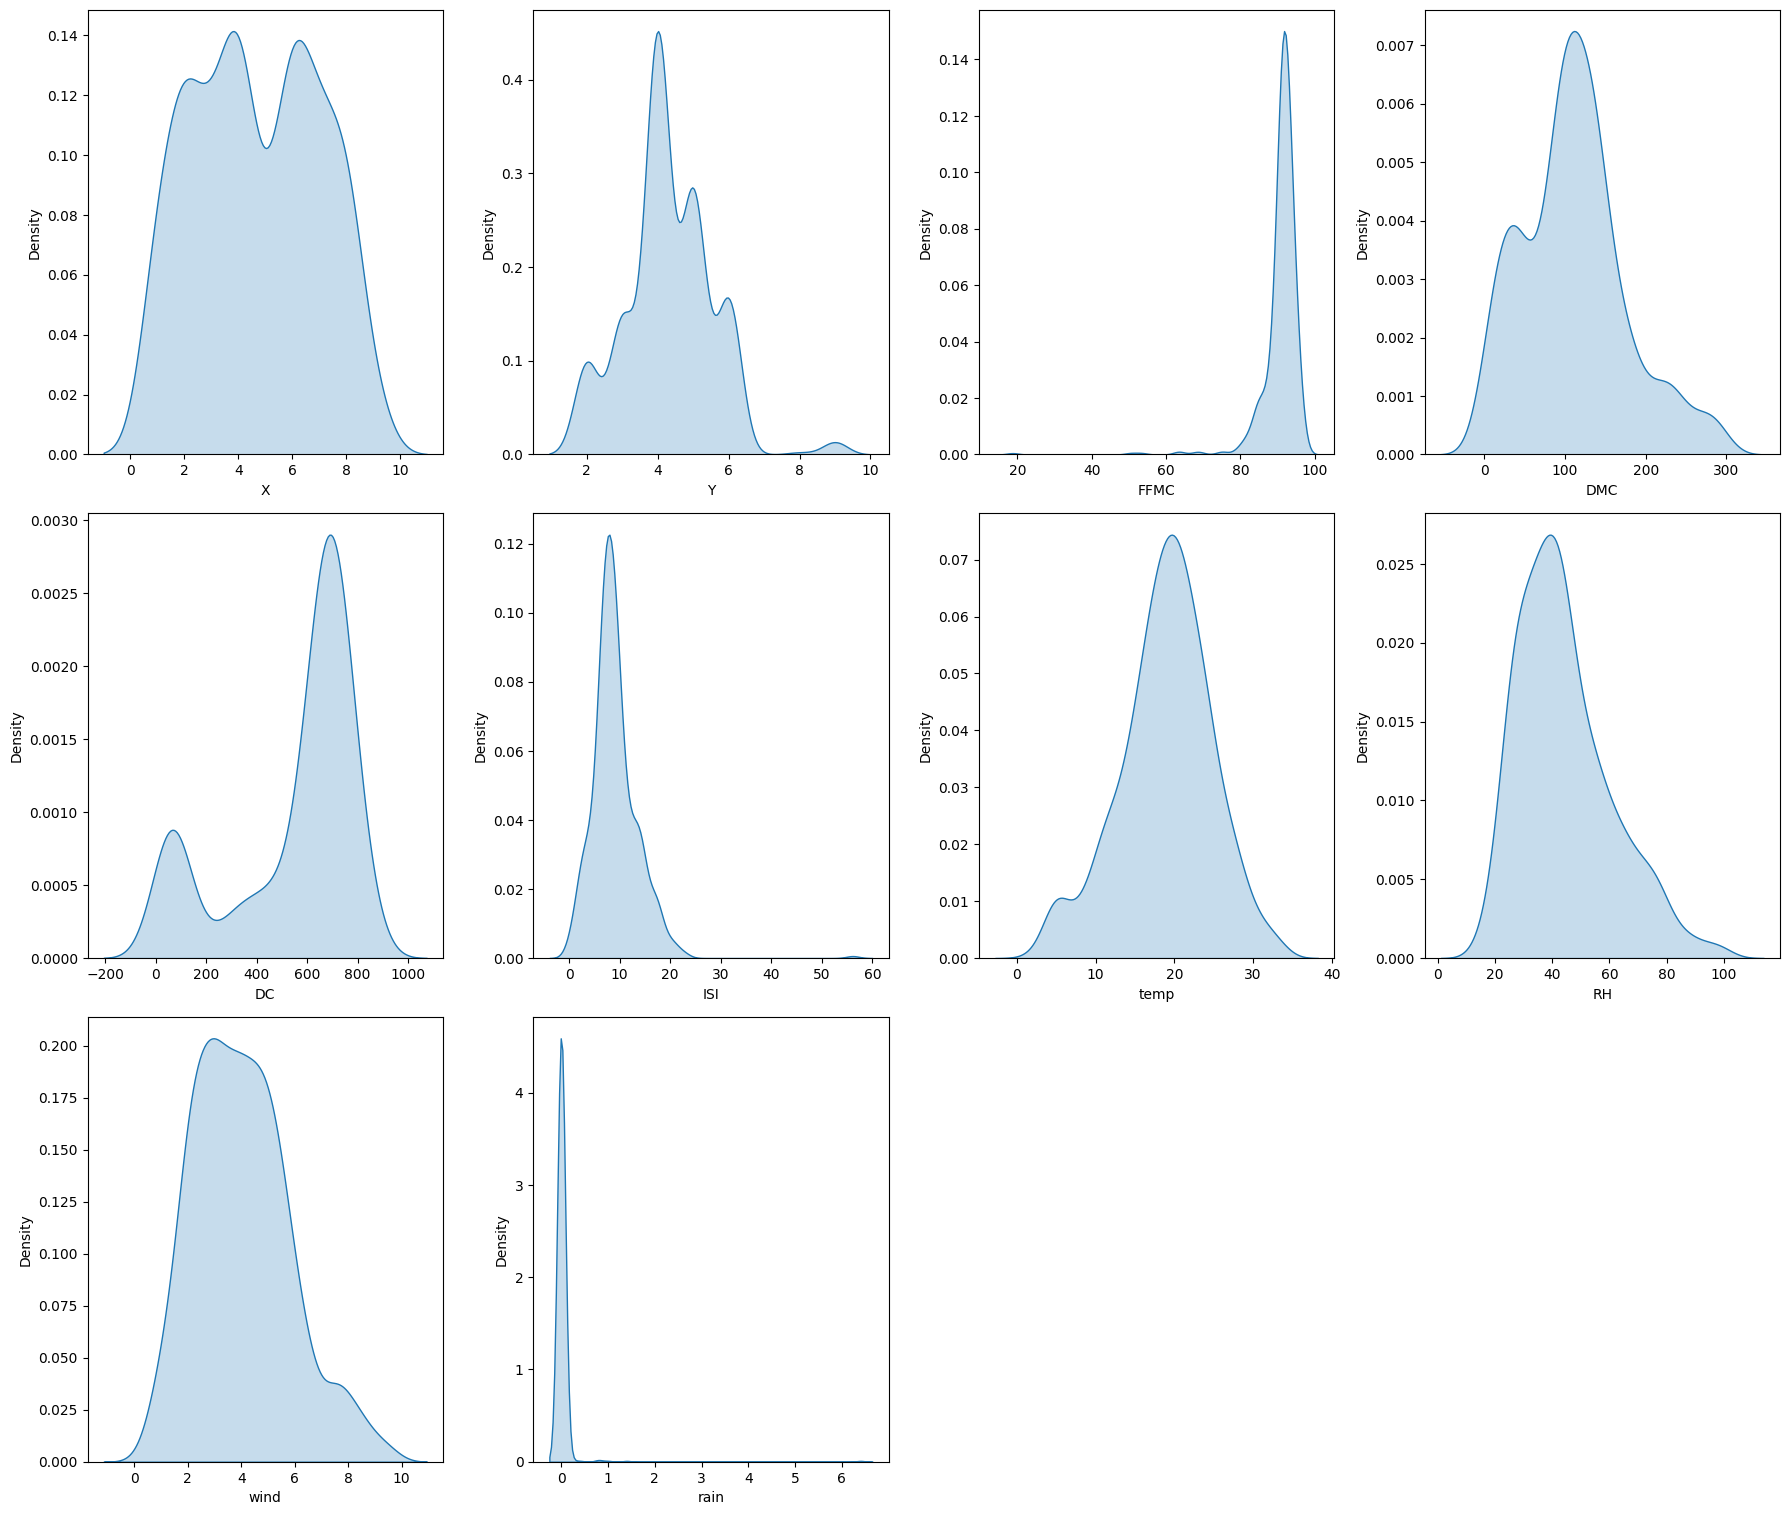

In [17]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(dataset_df[col],fill=True)
plt.tight_layout()
plt.show()

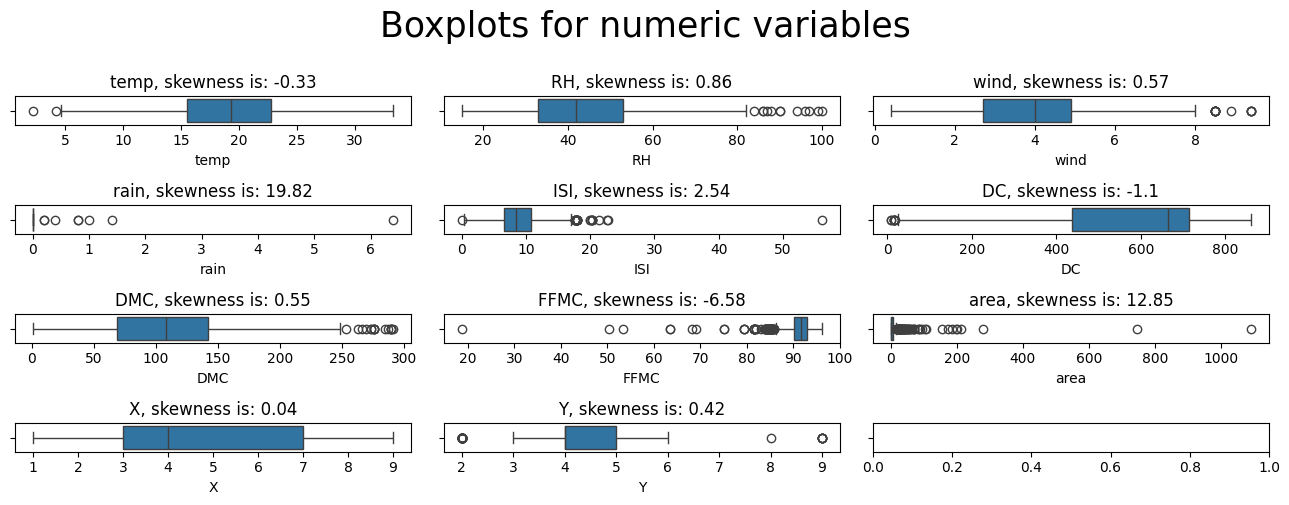

In [18]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(13,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

numerical_columns = list(dataset_df.loc[:,['temp','RH','wind','rain','ISI','DC','DMC',
                 'FFMC','area','X','Y' ]])

boxplots_custom(dataset=dataset_df, columns_list=numerical_columns, rows=4, cols=3, suptitle='Boxplots for numeric variables')
plt.tight_layout()

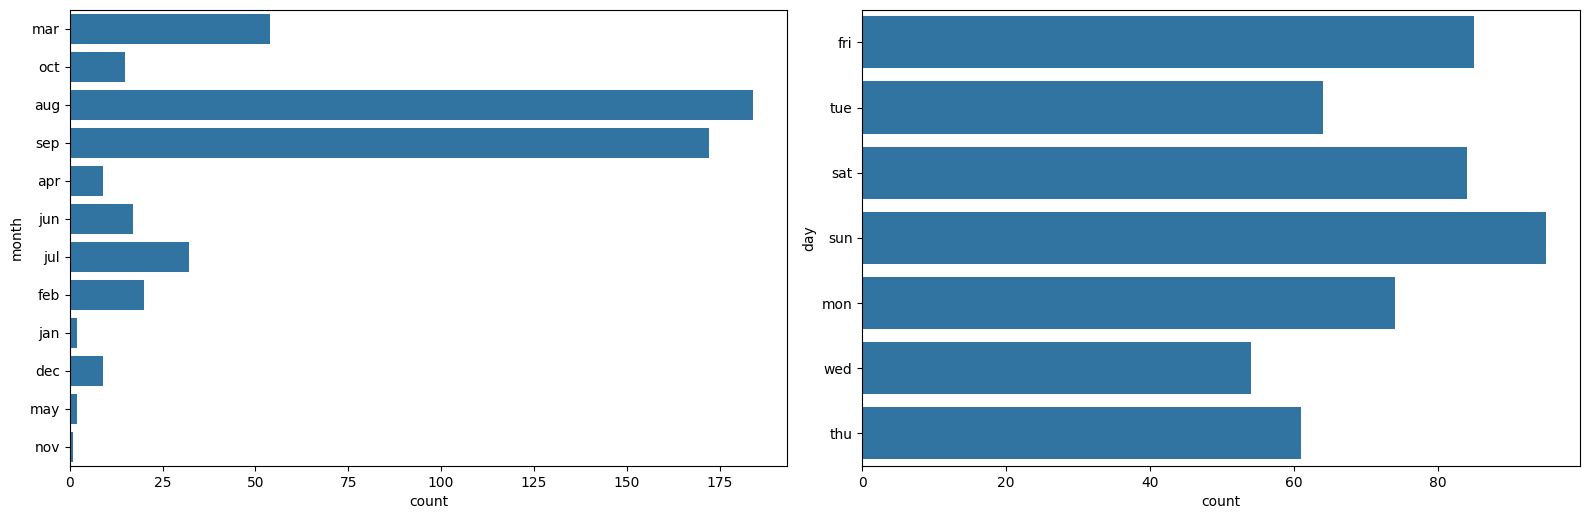

In [19]:
# From https://www.kaggle.com/code/psvishnu/forestfire-impact-prediction-stats-and-ml
plt.figure(figsize=(16,10))
for i,col in enumerate(cat_columns,1):
    plt.subplot(2,2,i)
    sns.countplot(data=dataset_df,y=col)
plt.tight_layout()
plt.show()

In [20]:
print('Number of rows with no damage:',dataset_df[dataset_df['area'] == 0.].shape[0])
print('Number of rows with damage:',dataset_df[dataset_df['area'] != 0.].shape[0])

Number of rows with no damage: 247
Number of rows with damage: 270


In [21]:
numerical_columns

['temp', 'RH', 'wind', 'rain', 'ISI', 'DC', 'DMC', 'FFMC', 'area', 'X', 'Y']

In [22]:
dataset_df[numerical_columns].corr()

,temp,RH,wind,rain,ISI,DC,DMC,FFMC,area,X,Y
temp,1.000000,-0.527390,-0.227116,0.069491,0.394287,0.496208,0.469594,0.431532,0.097844,-0.051258,-0.024103
RH,-0.527390,1.000000,0.069410,0.099751,-0.132517,-0.039192,0.073795,-0.300995,-0.075519,0.085223,0.062221
wind,-0.227116,0.069410,1.000000,0.061119,0.106826,-0.203466,-0.105342,-0.028485,0.012317,0.018798,-0.020341
rain,0.069491,0.099751,0.061119,1.000000,0.067668,0.035861,0.074790,0.056702,-0.007366,0.065387,0.033234
ISI,0.394287,-0.132517,0.106826,0.067668,1.000000,0.229154,0.305128,0.531805,0.008258,0.006210,-0.024488
DC,0.496208,-0.039192,-0.203466,0.035861,0.229154,1.000000,0.682192,0.330512,0.049383,-0.085916,-0.101178
DMC,0.469594,0.073795,-0.105342,0.074790,0.305128,0.682192,1.000000,0.382619,0.072994,-0.048384,0.007782
FFMC,0.431532,-0.300995,-0.028485,0.056702,0.531805,0.330512,0.382619,1.000000,0.040122,-0.021039,-0.046308
area,0.097844,-0.075519,0.012317,-0.007366,0.008258,0.049383,0.072994,0.040122,1.000000,0.063385,0.044873
X,-0.051258,0.085223,0.018798,0.065387,0.006210,-0.085916,-0.048384,-0.021039,0.063385,1.000000,0.539548


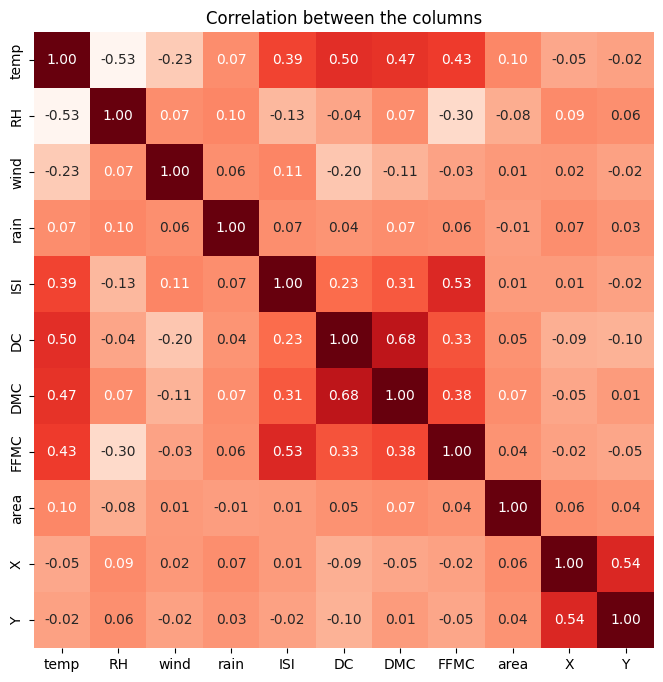

In [23]:
plt.figure(figsize=(8,8))
sns.heatmap(dataset_df[numerical_columns].corr(method='pearson', min_periods=1, numeric_only=True), annot=True, cbar=False, cmap='Reds', fmt='.2f')
plt.title("Correlation between the columns")
plt.show()

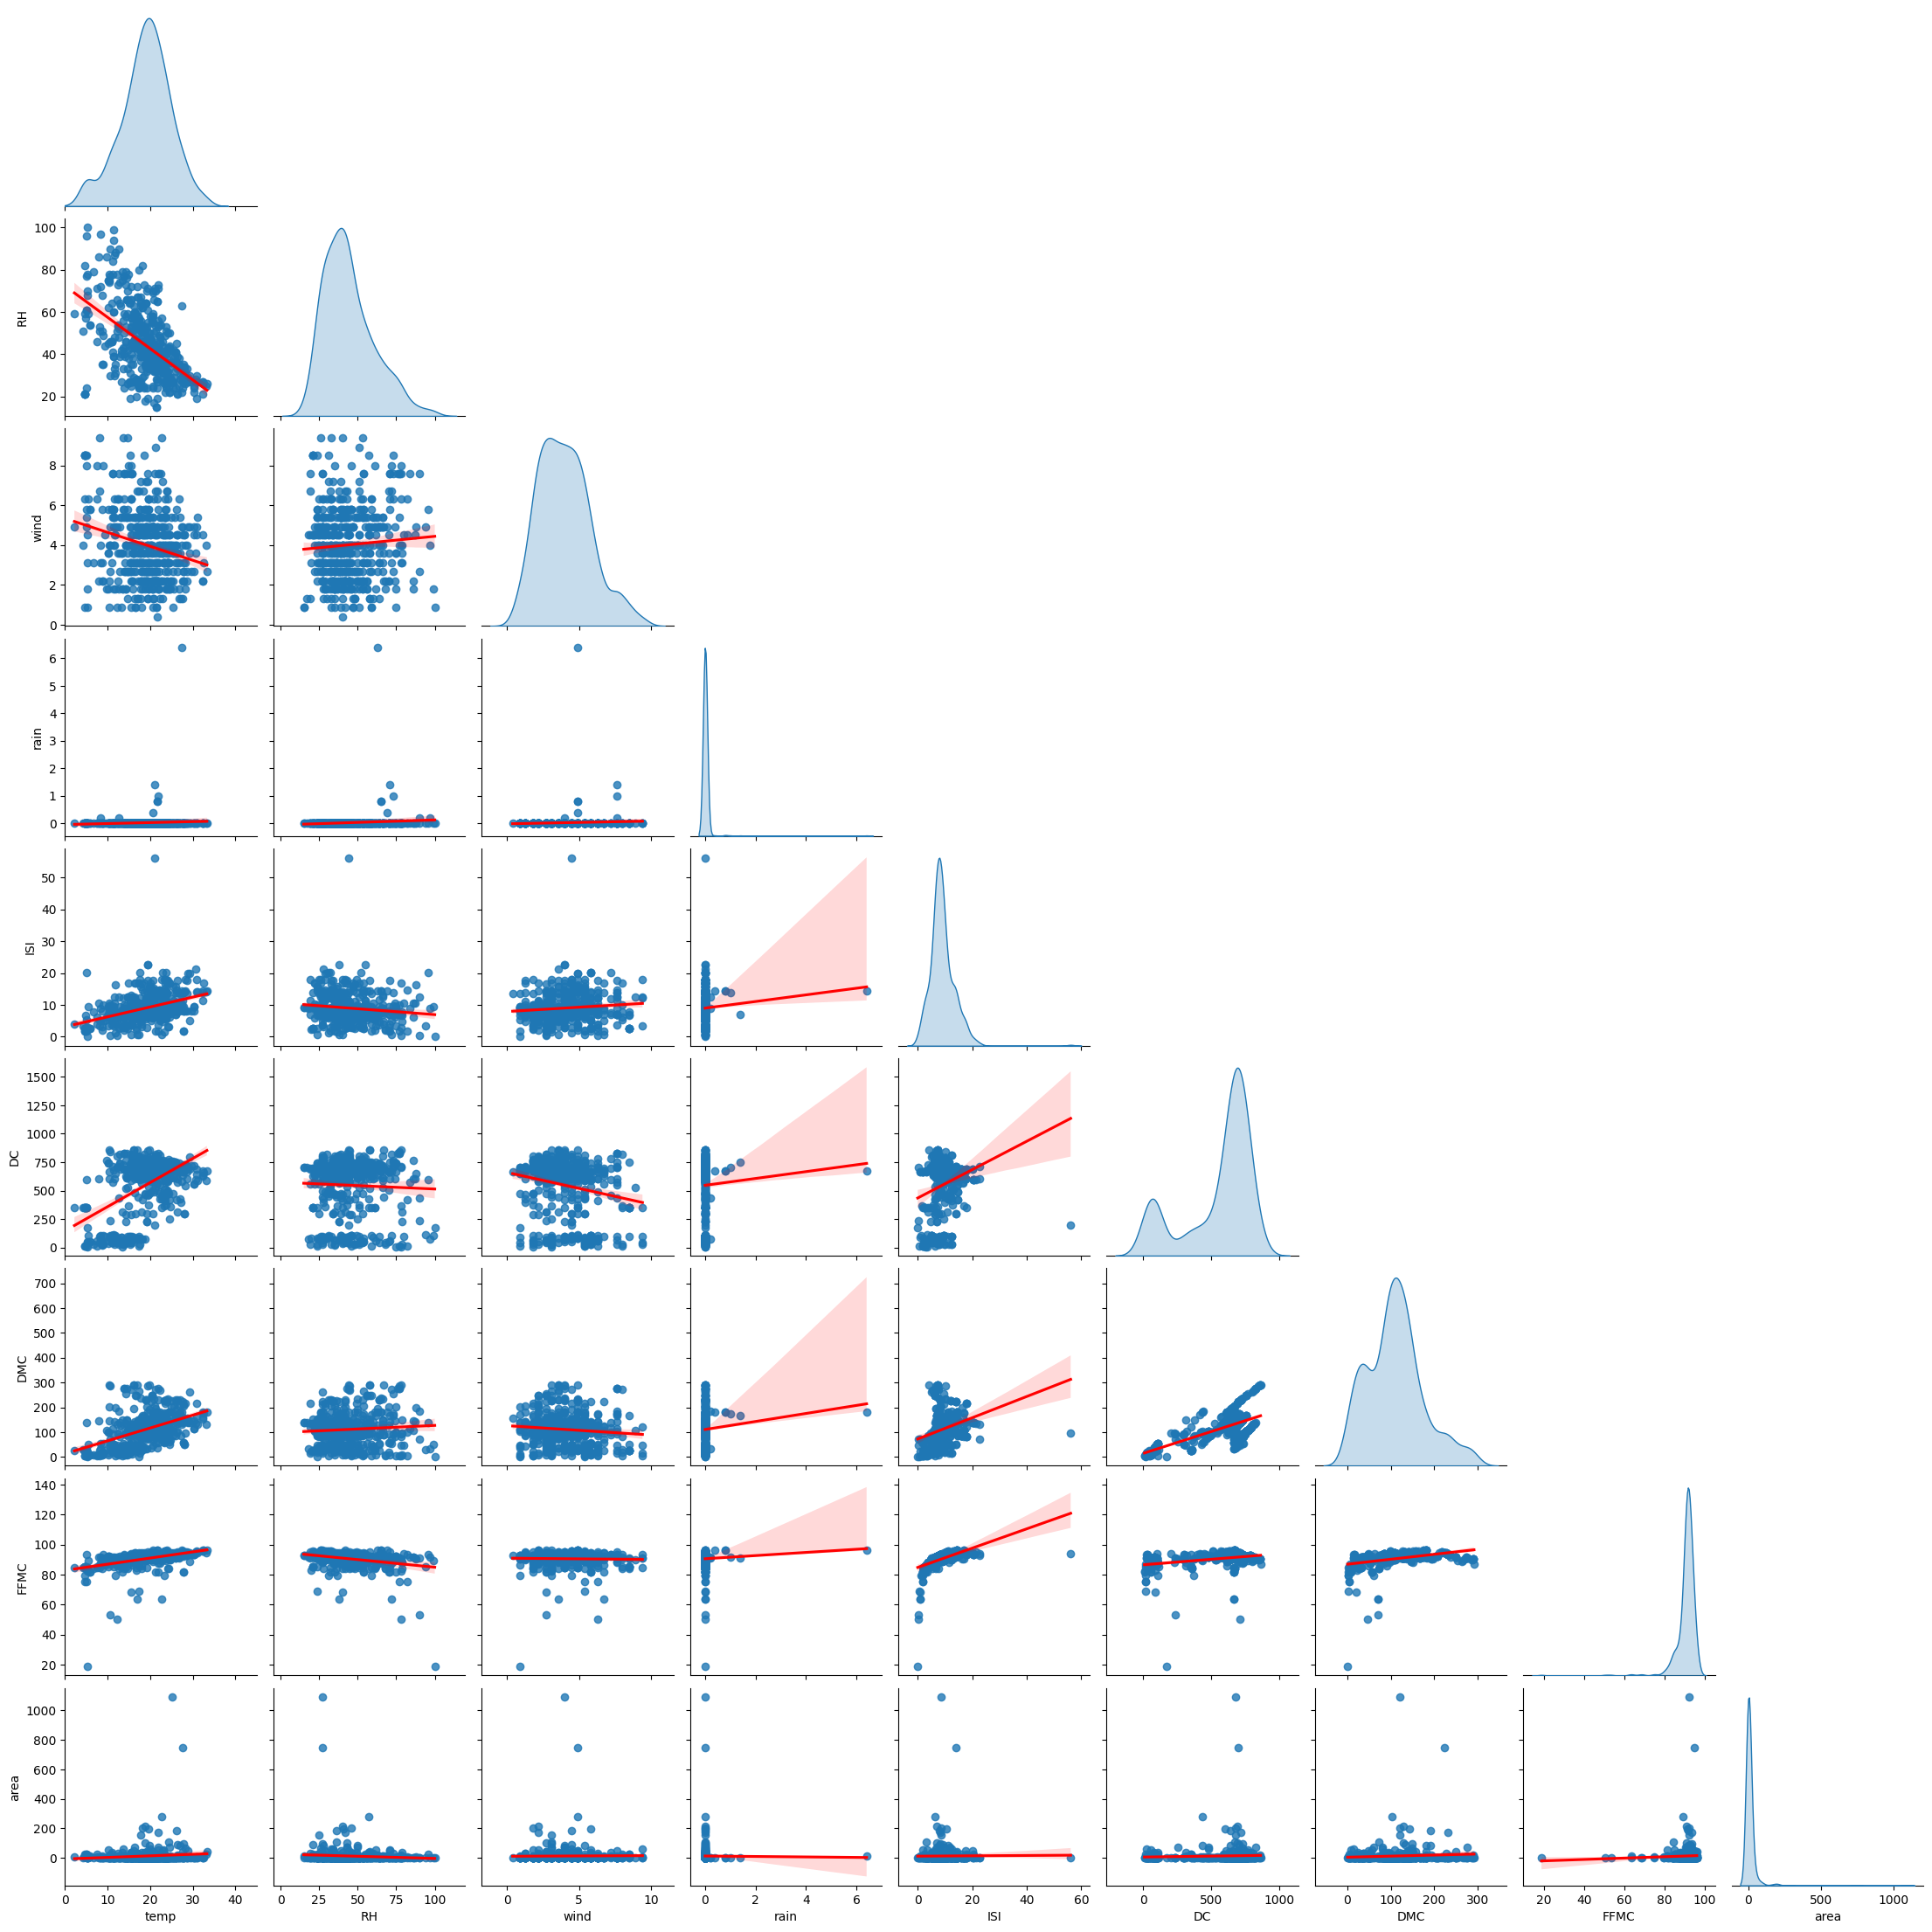

In [24]:
cols_plot = ['temp','RH','wind','rain','ISI','DC','DMC',
                 'FFMC','area']
g = sns.pairplot(dataset_df[cols_plot],diag_kind='kde',kind='reg',corner=True, plot_kws={'line_kws':{'color':'red'}})
for i in range(len(cols_plot)):
    g.axes[i,0].set_xlim((0,45))

In [25]:
# For visualization, may be helpful to make a
# categorical variable for whether or not there
# was any damage  (this will be dropped before model-building)
def damage_func(area):
    if area == 0.0:
        return "No damage"
    else:
        return "Damage"

dataset_df['damage'] = dataset_df['area'].apply(damage_func)

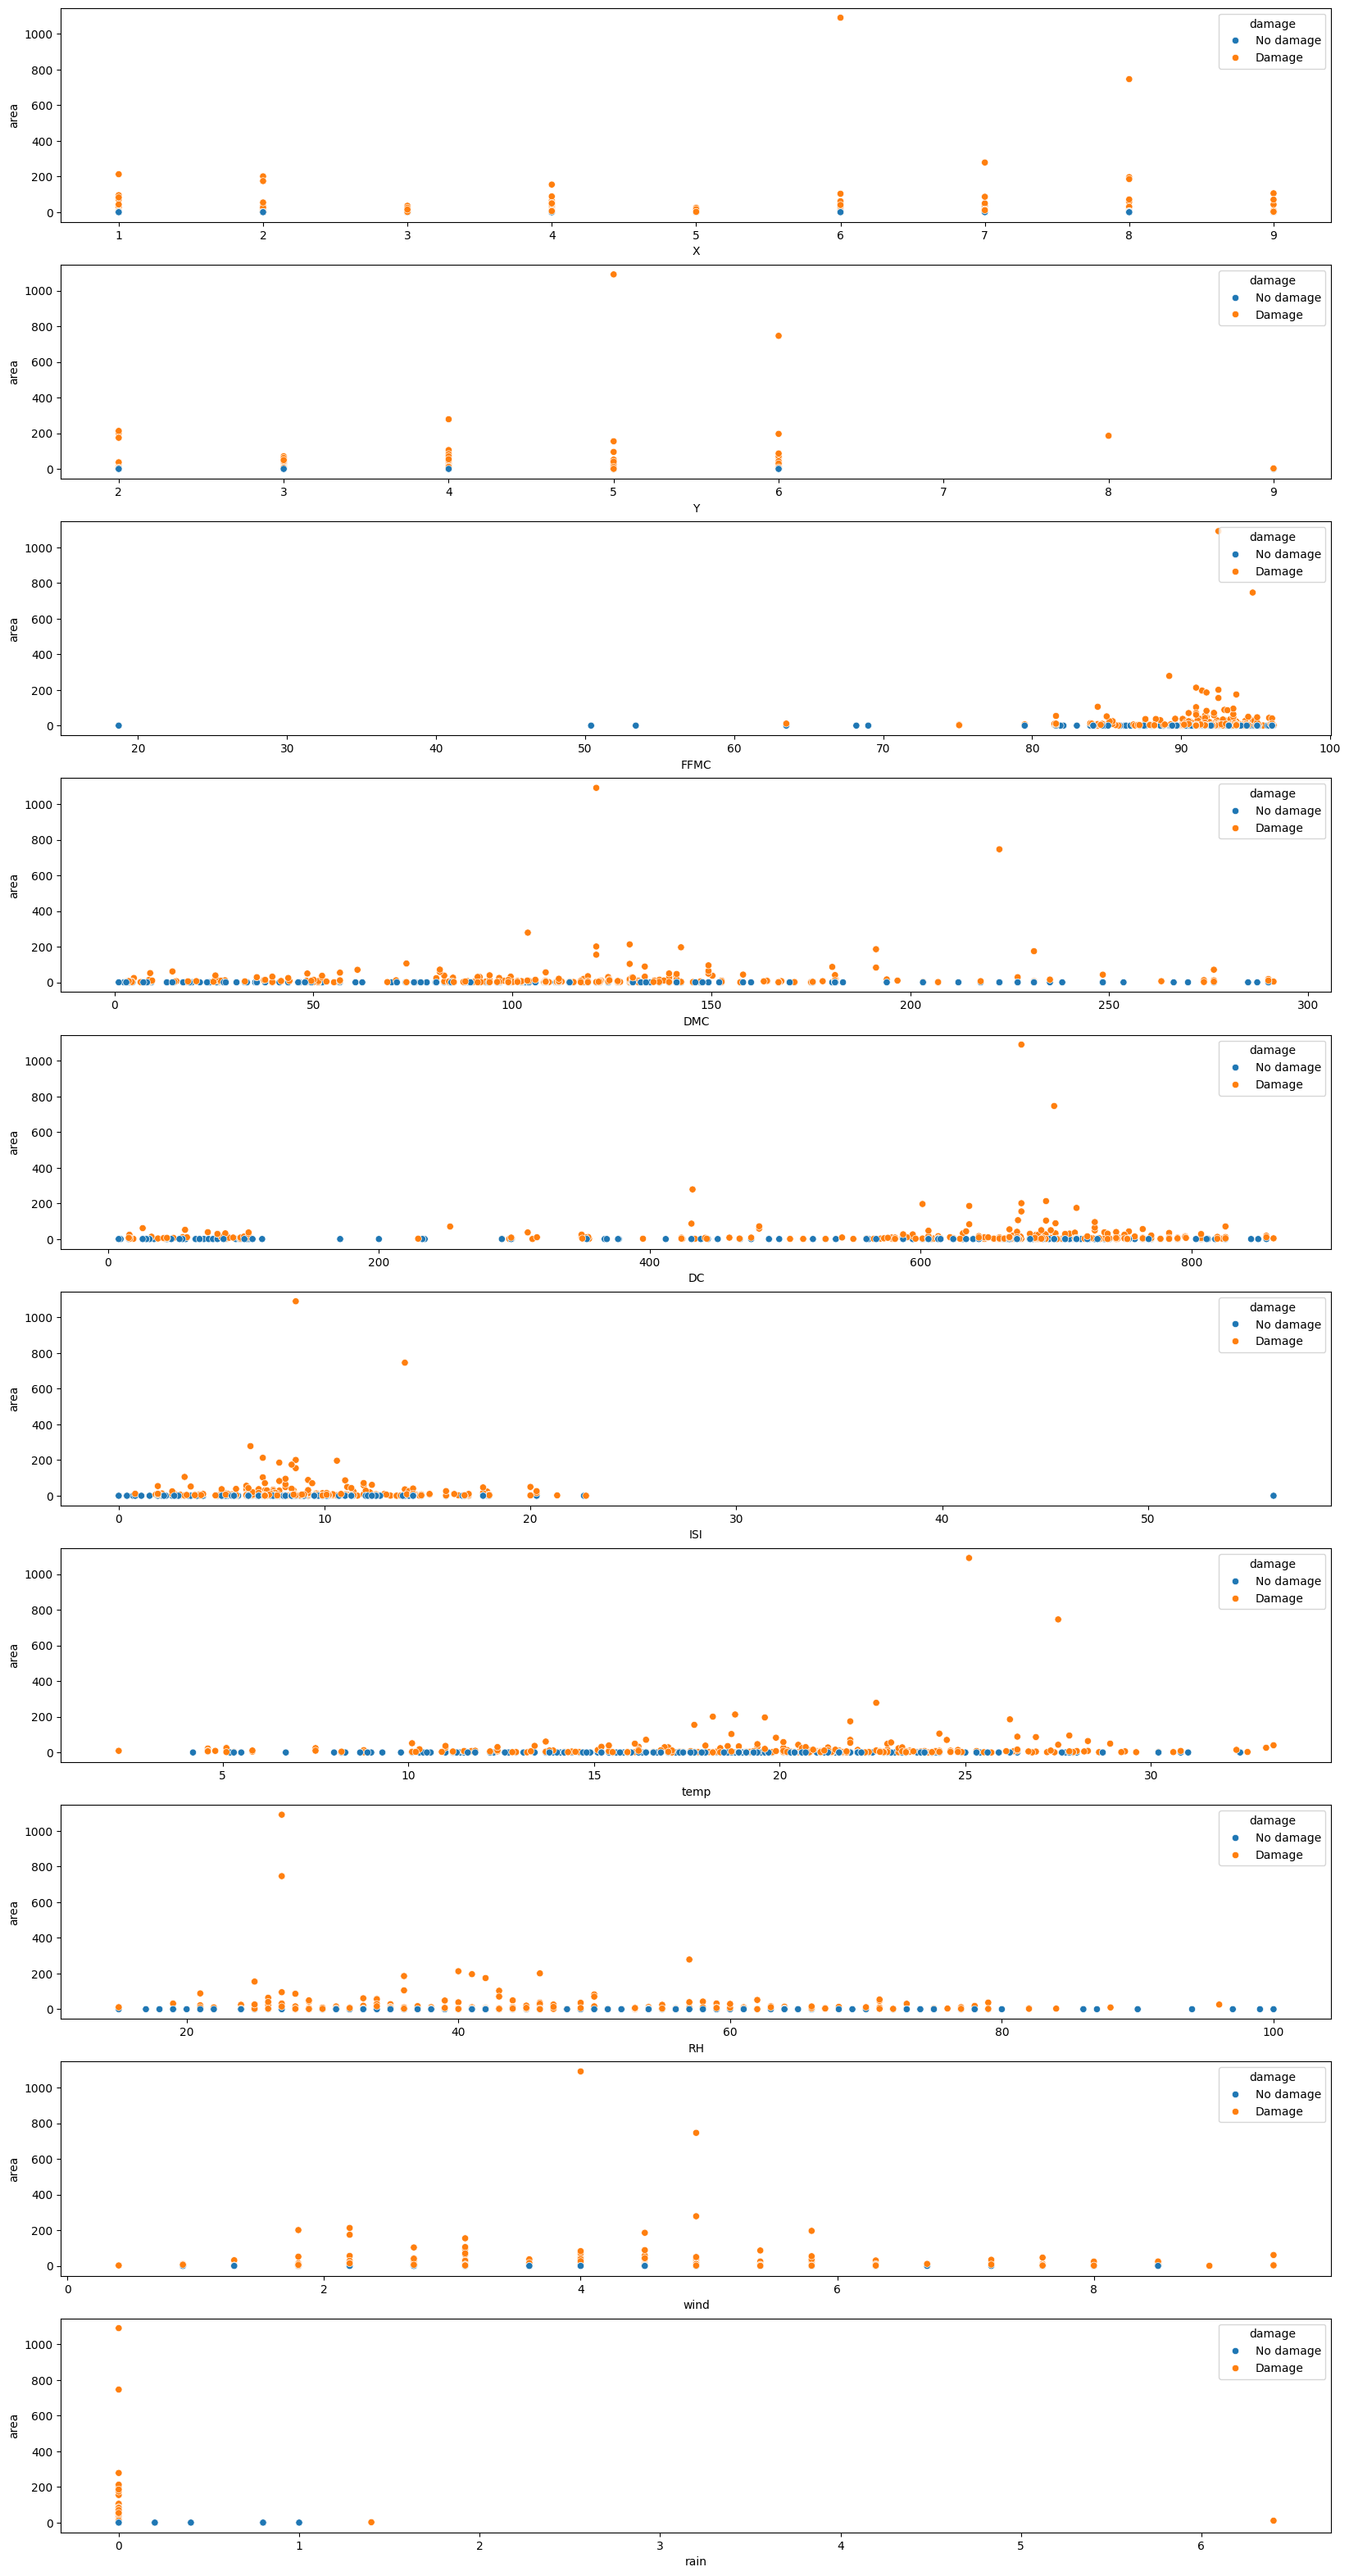

In [26]:
plt.figure(figsize=(20,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(10,1,i)
    sns.scatterplot(data=dataset_df,x=col,y='area',hue='damage')
plt.show()

#The use of the damage hue here is a bit redundant, but helps see low but non-zero areas

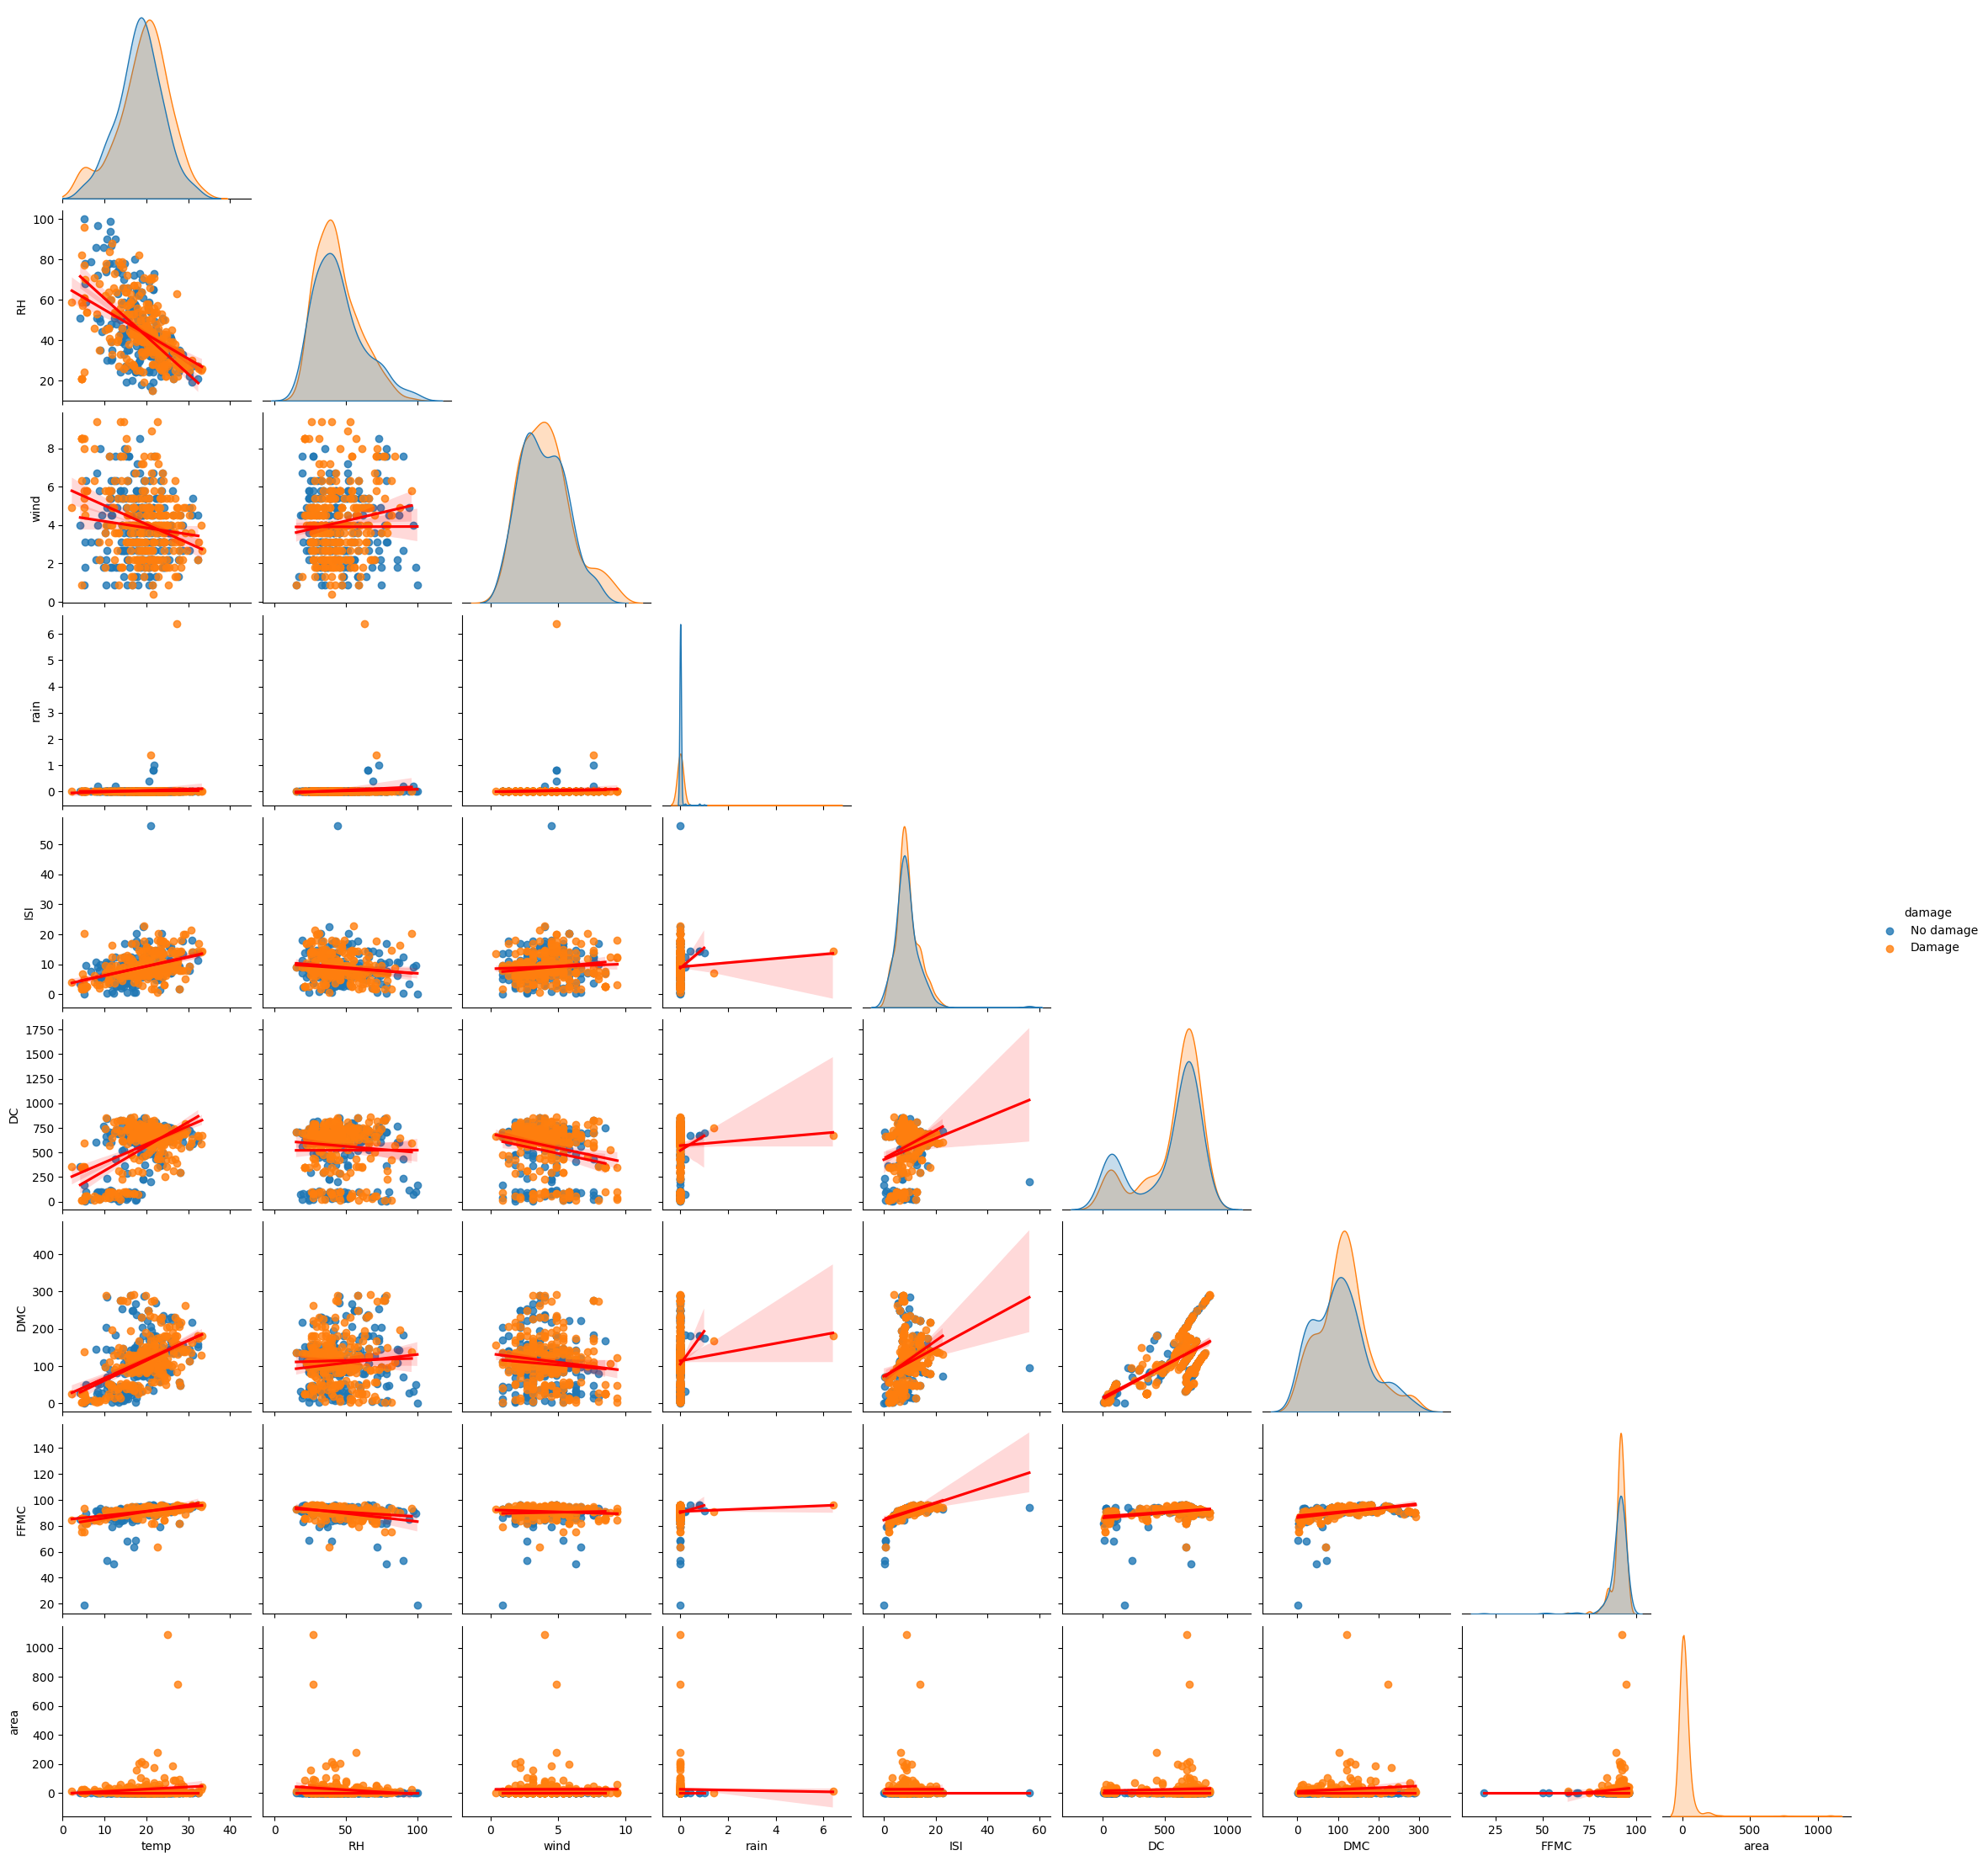

In [27]:
#selected_features = df.drop(columns=['damage','day','month']).columns
cols_plothue = ['temp','RH','wind','rain','ISI','DC','DMC',
                 'FFMC','area','damage']
g = sns.pairplot(dataset_df[cols_plothue],hue='damage',diag_kind='kde',kind='reg',corner=True, plot_kws={'line_kws':{'color':'red'}})#,vars=selected_features)
for i in range(len(cols_plot)):
    g.axes[i,0].set_xlim((0,45))
plt.show()

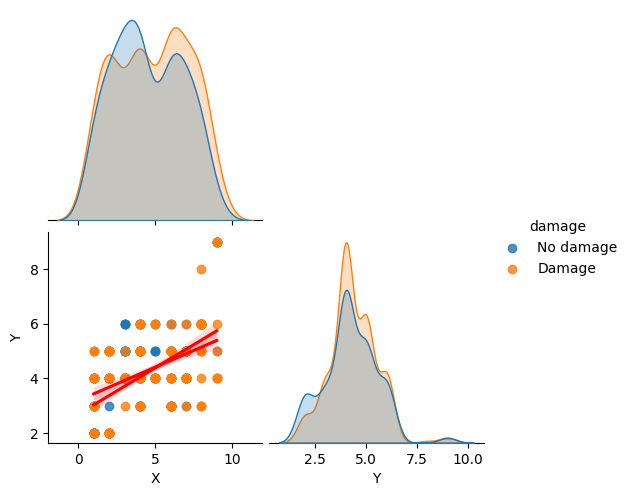

In [28]:
#cols_plothue = ['X','Y']
sns.pairplot(dataset_df[['X','Y','damage']],hue='damage',kind='reg',corner=True, plot_kws={'line_kws':{'color':'red'}})#,vars=selected_features)
#for i in range(len(cols_plot)):
#    g.axes[i,0].set_xlim((0,45))
plt.show()

In [29]:
# Before applying ML, should drop new category
dataset_df = dataset_df.drop('damage', axis=1)

In [30]:
# Categorical: Month and day
dataset_df = pd.get_dummies(dataset_df,columns=['day','month'],drop_first=True)

# Model

In [31]:
# Log transform
dataset_df['area'] = np.log(1 + dataset_df['area'])

# Creating bins of in the target, to stratify in train/test split
dataset_df['area_bin'] = pd.cut(dataset_df['area'], 5)
X = dataset_df.drop(columns='area')
y = dataset_df['area']

In [32]:
rmse_res = []
for i in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=i,
                                                   stratify=dataset_df[['area_bin']])
    X_train = X_train.drop(columns='area_bin',axis=1)
    X_test = X_test.drop(columns='area_bin',axis=1)

    lr = LinearRegression()

    lr.fit(X_train, Y_train)
    y_pred = np.exp(lr.predict(X_test)) - 1
    rmse = mean_squared_error(np.exp(Y_test)-1, y_pred,squared=False)
    #print('Random state = ',i)
    #print(f'RMSE: {rmse}')
    rmse_res.append(rmse)

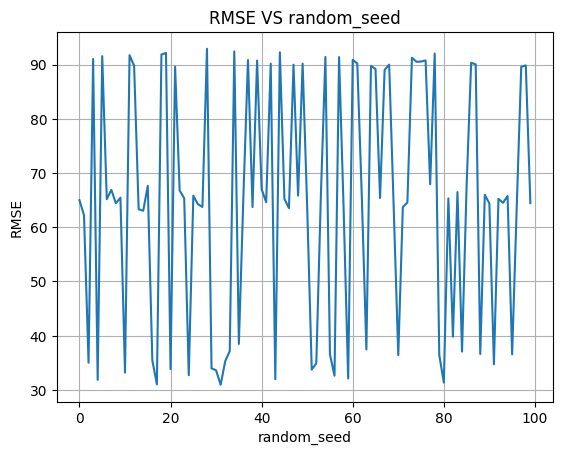

Mean:  64.76060698955546
Stdev:  21.732525937265823


In [33]:
plt.plot(rmse_res)
plt.title("RMSE VS random_seed")
plt.xlabel('random_seed')
plt.ylabel('RMSE')
plt.grid()
plt.show()
print('Mean: ',np.mean(rmse_res))
print('Stdev: ',np.std(rmse_res))

In [34]:
rs = 99
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=rs,
                                                   stratify=dataset_df[['area_bin']])
X_train = X_train.drop(columns='area_bin',axis=1)
X_test = X_test.drop(columns='area_bin',axis=1)

In [35]:
# Useful function for hyperparameter tuning
def Grid_and_eval(classifier,params,cv=10):
    parameters = params
    model_cv = GridSearchCV(classifier,parameters,cv=cv,
                            scoring='neg_root_mean_squared_error',
                            verbose=0,
                            error_score=np.nan)
    model_cv.fit(X_train,Y_train)
    print("Tuned hyperparameters: ",model_cv.best_params_)
    print("Mean CV score of best_estimator, on Training:",model_cv.best_score_)
    best_model = model_cv.best_estimator_
    print("Best estimator:",best_model)

    y_pred_test = np.exp(best_model.predict(X_test)) - 1
    y_pred_Train = np.exp(best_model.predict(X_train)) - 1
    rmse_Test = mean_squared_error(np.exp(Y_test)-1, y_pred_test,squared=False)
    rmse_Train = mean_squared_error(np.exp(Y_train)-1, y_pred_Train,squared=False)

    print(f'Test RMSE: {rmse_Test}')
    print(f'Train RMSE: {rmse_Train}')
    mae = mean_absolute_error(np.exp(Y_test)-1, y_pred_test)
    print(f'Test MAE: {mae}')

In [36]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
result = Grid_and_eval(RandomForestRegressor(random_state=rs),{
    'n_estimators': [100,300,500],
    'max_depth': [None,1,2],
    'min_samples_split': [1,2,3],
    'min_samples_leaf': [1,2,3,4]
},cv=10)

Tuned hyperparameters:  {'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 500}
Mean CV score of best_estimator, on Training: -1.381714176408448
Best estimator: RandomForestRegressor(max_depth=1, min_samples_leaf=3, n_estimators=500,
                      random_state=99)
Test RMSE: 64.4780096676812
Train RMSE: 64.46740603536259
Test MAE: 13.825770182400415


Test RMSE: 64.4780096676812
Train RMSE: 64.46740603536259
Test MAE: 13.825770182400415


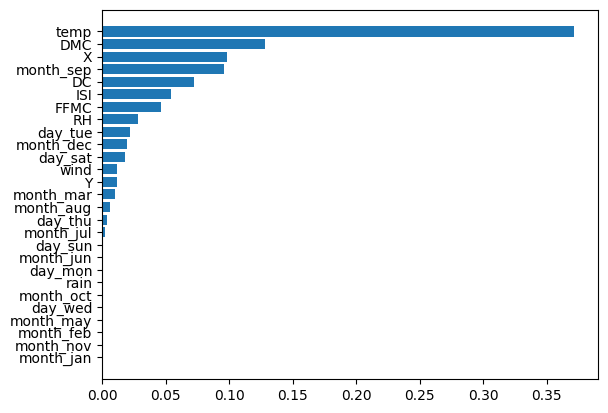

In [37]:
# Just redoing the above
rf = RandomForestRegressor(random_state=rs,
                           max_depth=1,min_samples_leaf=3,min_samples_split=2,
                           n_estimators=500)
rf.fit(X_train, Y_train)

y_pred_test = np.exp(rf.predict(X_test)) - 1
y_pred_Train = np.exp(rf.predict(X_train)) - 1
rmse_Test = mean_squared_error(np.exp(Y_test)-1, y_pred_test,squared=False)
rmse_Train = mean_squared_error(np.exp(Y_train)-1, y_pred_Train,squared=False)
print(f'Test RMSE: {rmse_Test}')
print(f'Train RMSE: {rmse_Train}')
mae = mean_absolute_error(np.exp(Y_test)-1, y_pred_test)
print(f'Test MAE: {mae}')

# Feature importance ----------------
importance = rf.feature_importances_
indices = np.argsort(importance)
fig, ax = plt.subplots()
ax.barh(range(len(importance)), importance[indices])
ax.set_yticks(range(len(importance)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

In [38]:
import joblib

# save
joblib.dump(rf, "random_forest_regressor_forestfire_data.pkl")



['random_forest_regressor_forestfire_data.pkl']

In [42]:
# load
rf = joblib.load("random_forest_regressor_forestfire_data.pkl")

# rf.predict(X[0:1])

RMSE: 64.4780096676812
MAE: 13.825770182400415


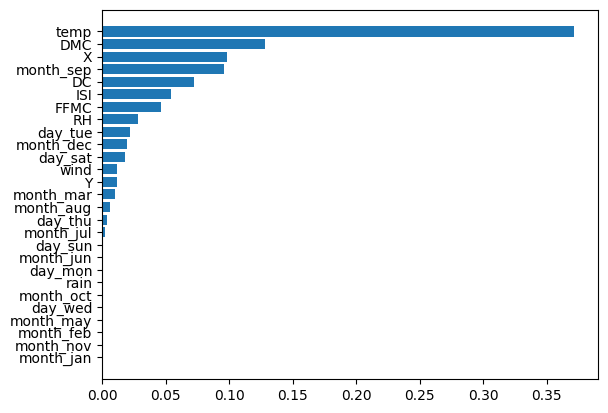

In [43]:
# rf = RandomForestRegressor()
# rf.fit(X_train, Y_train)

y_pred = np.exp(rf.predict(X_test)) - 1
rmse = mean_squared_error(np.exp(Y_test)-1, y_pred,squared=False)
mae = mean_absolute_error(np.exp(Y_test)-1, y_pred)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Feature importance ----------------
importance = rf.feature_importances_
indices = np.argsort(importance)
fig, ax = plt.subplots()
ax.barh(range(len(importance)), importance[indices])
ax.set_yticks(range(len(importance)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

# Shapley Flow

In [44]:
!pip install shapflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch

In [45]:
from google.colab import files
src = list(files.upload().values())[0]


Saving flow.py to flow.py
Saving on_manifold.py to on_manifold.py


In [46]:
open('flow.py','wb').write(src)
# import mylib

91226

In [48]:
open('on_manifold.py','wb').write(src)

11776

In [49]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.2 MB/s eta 0:00:00


In [50]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
import numpy as np
from collections import defaultdict
from graphviz import Digraph
import matplotlib.pyplot as plt
import pandas as pd
# from shapflow import flow
from flow import Node, CreditFlow, Graph, GraphExplainer, sample_graph, eval_graph
from on_manifold import OnManifoldExplainer, IndExplainer, FeatureAttribution

In [51]:
from shapflow import flow
flow.example_concise() # running the sanity check example in flow.py

bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 9182.33it/s]

credit x1->target: [1.]
credit x1->x2: [1.]
credit x2->target: [1.]


 ## Motivating Example of Forest Fire


  Some of the features are related to fuel codes: FFMC refers to moisture content surface litter and influences ignition and fire spread (ranges from 18.7 to 96.20).
DMC (1.1 to 291.3) and
DC (7.9 to 860.6) are the moisture content of shallow and deep organic layers.

ISI (0.0 to 56.10) is a score that correlates with fire velocity spread.

RH is relative humidity in percentage (15.0 to 100).
Temperature is in Celsius (2.2 to 33.30),
wind speed is in km/h (0.40 to 9.40), and
rain is in mm/m2 (0.0 to 6.4).


Identified causal relationships

Temperature effects FFMC, DMC, and DC (Positive Correlation)

RH effects  FFMC, DMC, and DC (Positive Correlation)

wind effects ISI

Rain Effects FFMC, DMC, and DC ( Negative Correlation)

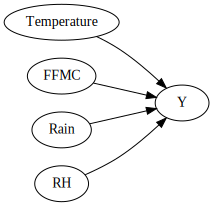

In [52]:
dot = Digraph(format='png')
dot.node('1', 'Temperature ')
dot.node('2', 'FFMC')
dot.node('3', 'Rain ')
dot.node('4', 'RH')
dot.node('y', 'Y')

dot.edge('1', 'y')
dot.edge('2', 'y')
dot.edge('3', 'y')
dot.edge('4', 'y')

dot.graph_attr['rankdir']='LR'
dot

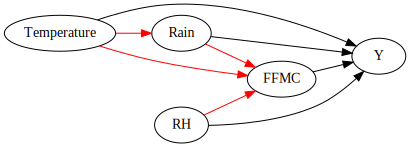

In [54]:
dot = Digraph()
dot.node('1', 'Temperature')
dot.node('2', 'FFMC')
dot.node('3', 'Rain ')
dot.node('4', 'RH')
dot.node('y', 'Y')

dot.edge('1', '2', color='red')
dot.edge('1', '3', color='red')
dot.edge('4', '2', color='red')
dot.edge('3', '2', color='red')


dot.edge('1', 'y')
dot.edge('2', 'y')
dot.edge('3', 'y')
dot.edge('4', 'y')

dot.graph_attr['rankdir']='LR'
dot

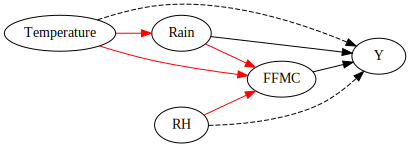

In [61]:
# the causal graph visualization
dot = Digraph()
dot.node('1', 'Temperature')
dot.node('2', 'FFMC')
dot.node('3', 'Rain ')
dot.node('4', 'RH')
dot.node('y', 'Y')

dot.edge('1', '2', color='red')
dot.edge('1', '3', color='red')
dot.edge('4', '2', color='red')
dot.edge('3', '2', color='red')

dot.edge('1', 'y', style='dashed')
dot.edge('2', 'y')
dot.edge('3', 'y')
dot.edge('4', 'y',  style='dashed')


dot.graph_attr['rankdir']='LR'
dot

In [113]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2->x3, y = f(x1, x2,x3)
    x1 = Node('Temperature')
    x2 = Node('FFMC',lambda x1: x1 + 1, [x1])
    x3  = Node('Rain', lambda x1: 1-x1, [x1])
    x4 = Node('RH', lambda :0)
    # y =  Node('Y',   x1, lambda x1, x3 : x3,[x1, x3] )

    y  = Node('y', lambda x1, x3: x3,
              [x1, x3], is_target_node=True)

    # initialize the values from data
    graph = Graph([x1, x2, x3,x4, y])
    return graph


graph_for = build_graph() # the causal graph
bg_for = sample_graph(graph_for, {'Temperature': 0})[['Temperature','Rain','FFMC','RH']] # background: hot
fg_for = sample_graph(graph_for, {'Temperature': 1})[['Temperature', 'Rain','FFMC','RH']] # foreground: cold
f_for = lambda x: x[:, 1] # function to explain only care about RH

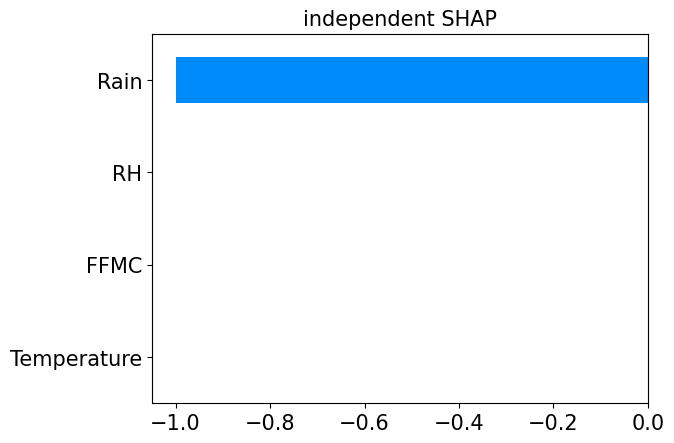

In [119]:
cf_ind = IndExplainer(f_for, bg_for, silent=True).shap_values(fg_for)
cf_ind.draw(0) # show the person with index 0 (here we only have 1 person to explain)
plt.title('independent SHAP', fontsize=15)
plt.show()

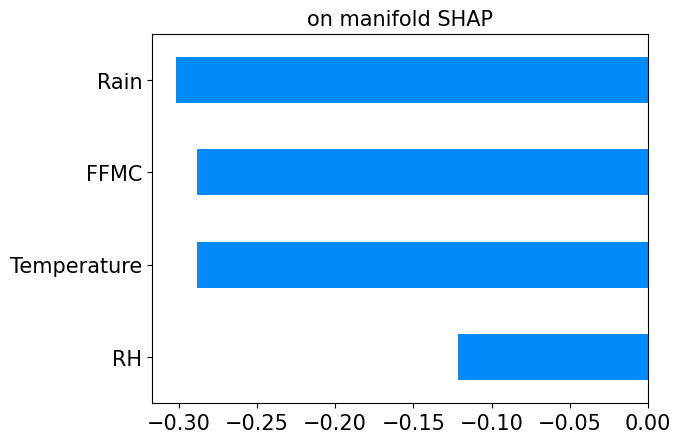

In [120]:
# on manifold SHAP
cf_ind = OnManifoldExplainer(f_for, pd.concat([bg_for, fg_for]), silent=True).shap_values(fg_for)
cf_ind.draw(0) # show the person with index 0 (here we only have 1 person to explain)
plt.title('on manifold SHAP', fontsize=15)
plt.show()

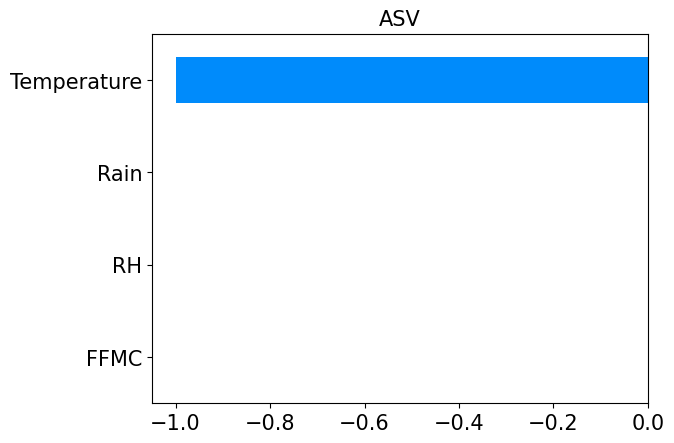

In [123]:
# ASV: restricting the order of on manifold methods
cf_asv = OnManifoldExplainer(f_for, pd.concat([bg_for, fg_for]), orderings=[[0, 1,2,3]], silent=True).shap_values(fg_for)
cf_asv.draw(0) # show the person with index 0 (here we only have 1 person to explain)
plt.title('ASV', fontsize=15)
plt.show()

bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

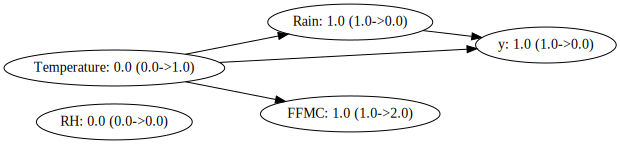


----> using order [RH, Temperature]
background RH: 0, Temperature: 0
turn on edge from external source to RH
RH changes from 0 to 0


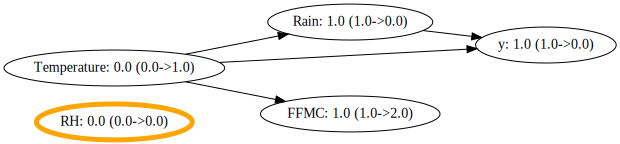

turn on edge from external source to Temperature
Temperature changes from 0 to 1


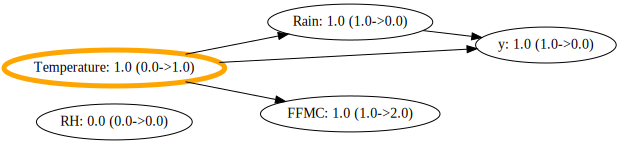

turn on edge Temperature->y
y changes from 1 to 1


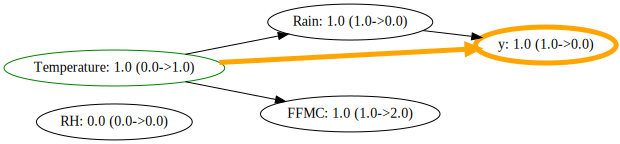

assign 0 credit to Temperature->y


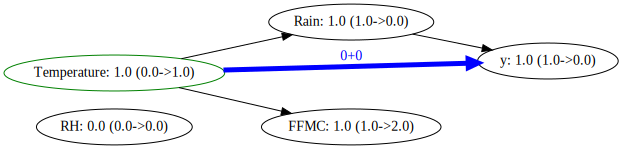

turn on edge Temperature->FFMC
FFMC changes from 1 to 2


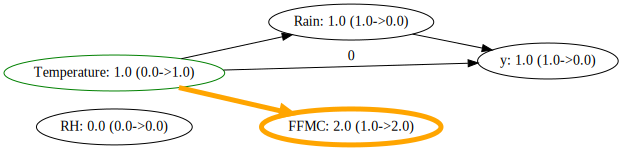

turn on edge Temperature->Rain
Rain changes from 1 to 0


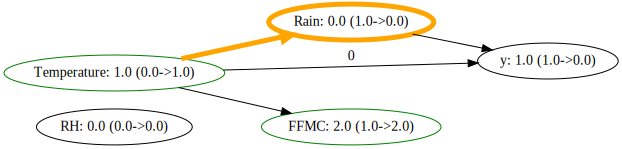

turn on edge Rain->y
y changes from 1 to 0


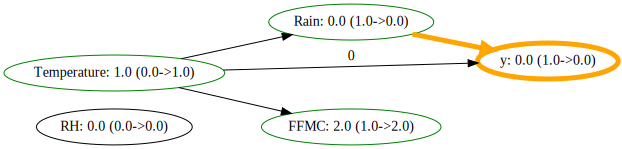

assign -1 credits to Rain->y


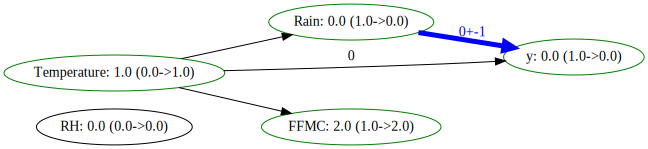

assign -1 credits to Temperature->Rain


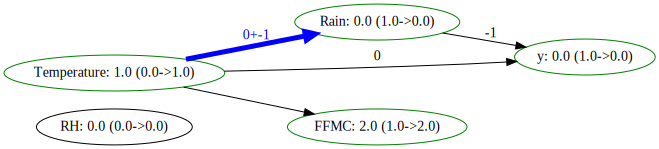

bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


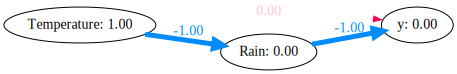

In [125]:
cf = GraphExplainer(graph_for, bg_for, nruns=1).shap_values(fg_for, verbose=True, visualize=True, rankdir='LR')
d = cf.draw(0)

Shapley Flow


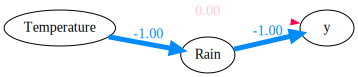

In [127]:
print('Shapley Flow')
cf_flow = GraphExplainer(graph_for, bg_for, silent=True).shap_values(fg_for, rankdir='LR') # rankdir is for visualization direction
d = cf_flow.draw(0, show_fg_val=False) # show the person with index 0 (here we only have 1 person to explain)

## Shapley Flow Example


I will traslate it to our case

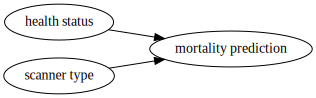

In [58]:
dot = Digraph(format='png')
dot.node('1', 'health status')
dot.node('2', 'scanner type')
dot.node('y', 'mortality prediction')

dot.edge('1', 'y')
dot.edge('2', 'y')
dot.graph_attr['rankdir']='LR'
dot

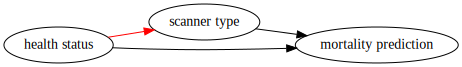

In [59]:
dot = Digraph()
dot.node('1', 'health status')
dot.node('2', 'scanner type')
dot.node('y', 'mortality prediction')

dot.edge('1', '2', color='red')
dot.edge('1', 'y')
dot.edge('2', 'y')
dot.graph_attr['rankdir']='LR'
dot

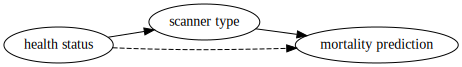

In [60]:
# the causal graph visualization
dot = Digraph()
dot.node('1', 'health status')
dot.node('2', 'scanner type')
dot.node('y', 'mortality prediction')

dot.edge('1', '2')
dot.edge('1', 'y', style='dashed')
dot.edge('2', 'y')
dot.graph_attr['rankdir']='LR'
dot

In [108]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    x2 = Node('scanner type', lambda x1: 1-x1, [x1])
    y  = Node('mortality prediction', lambda x1, x2: x2,
              [x1, x2], is_target_node=True)

    # initialize the values from data
    graph = Graph([x1, x2, y])
    return graph


graph = build_graph() # the causal graph
bg = sample_graph(graph, {'health status': 0})[['health status', 'scanner type']] # background: an unhealthy person
fg = sample_graph(graph, {'health status': 1})[['health status', 'scanner type']] # foreground: a healthy person
f = lambda x: x[:, 1] # function to explain only care about scanner type

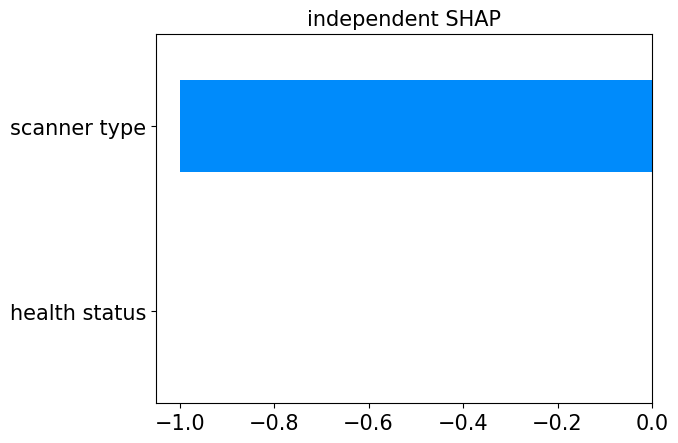

In [109]:
# independent SHAP
cf_ind = IndExplainer(f, bg, silent=True).shap_values(fg)
cf_ind.draw(0) # show the person with index 0 (here we only have 1 person to explain)
plt.title('independent SHAP', fontsize=15)
plt.show()

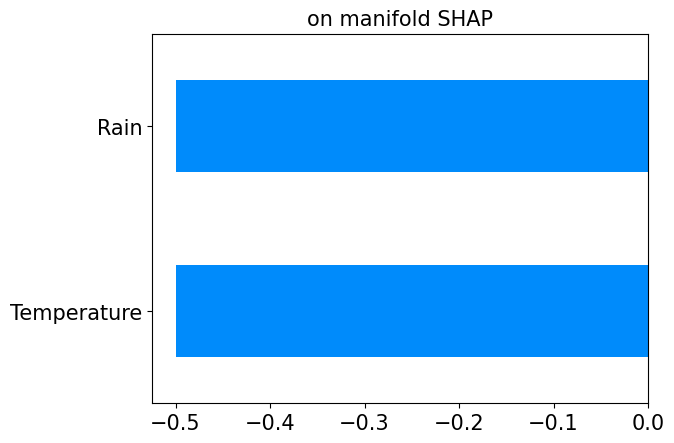

In [94]:
# on manifold SHAP
cf_ind = OnManifoldExplainer(f, pd.concat([bg, fg]), silent=True).shap_values(fg)
cf_ind.draw(0) # show the person with index 0 (here we only have 1 person to explain)
plt.title('on manifold SHAP', fontsize=15)
plt.show()

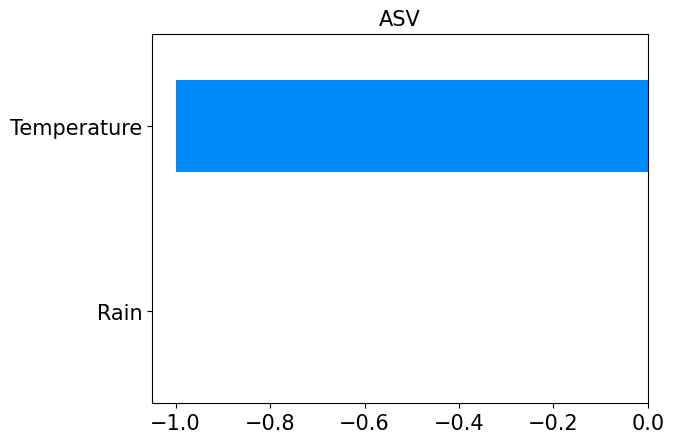

In [95]:
# ASV: restricting the order of on manifold methods
cf_asv = OnManifoldExplainer(f, pd.concat([bg, fg]), orderings=[[0, 1]], silent=True).shap_values(fg)
cf_asv.draw(0) # show the person with index 0 (here we only have 1 person to explain)
plt.title('ASV', fontsize=15)
plt.show()

In [ ]:
cf = GraphExplainer(graph, bg, nruns=1).shap_values(fg, verbose=True, visualize=True, rankdir='LR')
d = cf.draw(0)

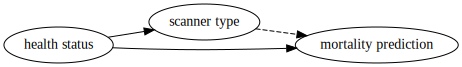

In [96]:
# the causal graph visualization
dot = Digraph()
dot.node('1', 'health status')
dot.node('2', 'scanner type')
dot.node('y', 'mortality prediction')

dot.edge('1', '2')
dot.edge('1', 'y')
dot.edge('2', 'y', style='dashed')
dot.graph_attr['rankdir']='LR'
dot


In [97]:
def build_graph2():
    '''
    show on manifold and ASV are invariant to this graph
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    x2 = Node('scanner type', lambda x1: 1-x1, [x1])
    y  = Node('mortality prediction', lambda x1, x2: x2,
              [x1, x2], is_target_node=True)

    # initialize the values from data
    graph = Graph([x1, x2, y])
    return graph

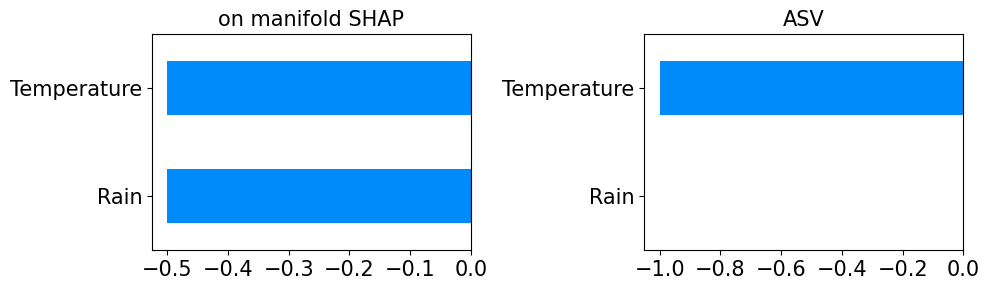

In [98]:
graph2 = build_graph2() # the causal graph
f2 = lambda x: 1 - x[:, 0] # function to explain only care about health status

plt.figure(figsize=(10, 3))
plt.subplot(121)
cf_manifold = OnManifoldExplainer(f2, pd.concat([bg, fg]), silent=True).shap_values(fg)
cf_manifold.draw(0)
plt.title('on manifold SHAP', fontsize=15)

plt.subplot(122)
cf_asv = OnManifoldExplainer(f2, pd.concat([bg, fg]), silent=True, orderings=[[0, 1]]).shap_values(fg)
cf_asv.draw(0)
plt.title('ASV', fontsize=15)
plt.tight_layout()
plt.show()

Shapley Flow


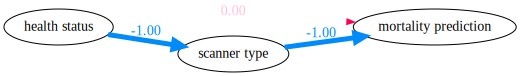

In [105]:
print('Shapley Flow')
cf_flow = GraphExplainer(graph, bg, silent=True).shap_values(fg, rankdir='LR') # rankdir is for visualization direction
d = cf_flow.draw(0, show_fg_val=False) # show the person with index 0 (here we only have 1 person to explain)

In [126]:
def build_graph_complex(): # graph associated with the above figure
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x00 = Node('enough exercise') # {0, 1}
    x01 = Node('sleep quality') # {0, 1}
    x1 = Node('health status', lambda x00, x01: x00 and x01, [x00, x01])
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', # low health leads to portable scanner more often
              lambda health, noise: (0.9 > noise if health <= 0.1 else 0.3 > noise).astype(int), [x1, n2])
    y  = Node('mortality prediction', lambda x00, x01, x1, x2: x2,
              [x00, x01, x1, x2], is_target_node=True)

    # initialize the values from data
    graph = Graph([x00, x01, x1, n2, x2, y], # background: unhealthy, foreground: healthy
                 {
                      'enough exercise': lambda: 0,
                      'sleep quality': lambda: 0,
                      'scanner type noise': lambda: np.random.uniform(0, 1)
                 },
                 {
                      'enough exercise': lambda: 1,
                      'sleep quality': lambda: 1,
                      'scanner type noise': lambda: np.random.uniform(0, 0.9), # target is invariant
                 })

    return graph

graph_complex = build_graph_complex()

In [101]:
!apt-get update
!apt-get install -y graphviz graphviz-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,552 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,443 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,218 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,861 kB]
Get:14 http://archive.ub

In [102]:
!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.13-cp310-cp310-linux_x86_64.whl size=168493 sha256=4fc284813951aed92723d96e436c9b8eda72edfec3032990f61bf00446c5f0cb
  Stored in directory: /root/.cache/pip/wheels/c5/96/10/6c25add1fffc368b1927252bf73b63fcb938de8f4486e23691
Successfully built pygraphviz


bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

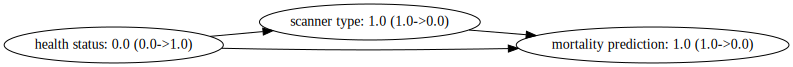


----> using order [health status]
background health status: 0
turn on edge from external source to health status
health status changes from 0 to 1


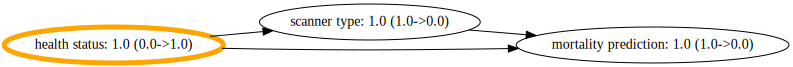

turn on edge health status->scanner type
scanner type changes from 1 to 0


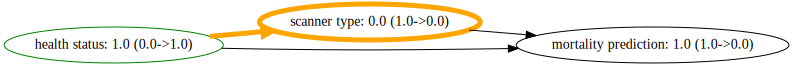

turn on edge scanner type->mortality prediction
mortality prediction changes from 1 to 0


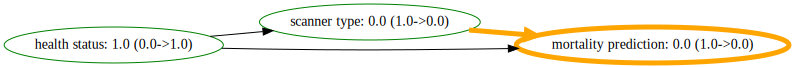

assign -1 credits to scanner type->mortality prediction


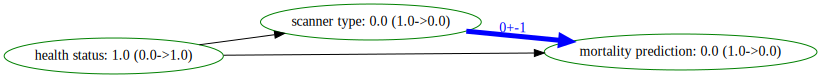

assign -1 credits to health status->scanner type


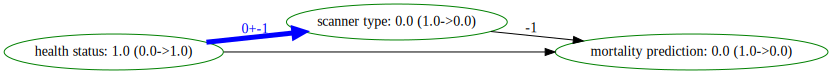

turn on edge health status->mortality prediction
mortality prediction changes from 0 to 0


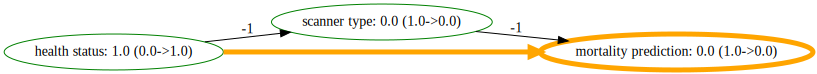

assign 0 credit to health status->mortality prediction


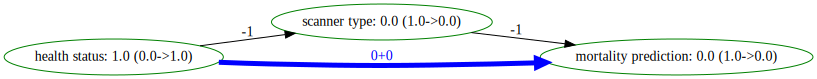

bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


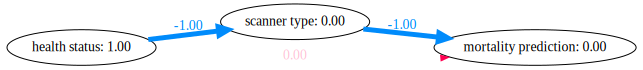

In [106]:
cf = GraphExplainer(graph, bg, nruns=1).shap_values(fg, verbose=True, visualize=True, rankdir='LR')
d = cf.draw(0)